# Model Evaluation  
  
Here we examine model performances from the previous step and choose the best model for each representation

In [1]:
import os
import re 
import ast
import random
import numpy as np
import pandas as pd  
  
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, f1_score, precision_score, recall_score


import matplotlib.pyplot as plt

from numpy import argmax, nanargmax

import seaborn as sns



## Directory setup

In [2]:
MODEL_TRAIN_DIR = "../data/02.model_training/"
SCREEN_DATA_DIR = "../data/01.prepare_training_data/"

OUTPUT_DIR = "../data/03.model_evaluation/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Read training output and determine best models

In [3]:
# Read performance data
performance_df = pd.read_csv(os.path.join(MODEL_TRAIN_DIR, "strain_performance.tsv.gz"), sep='\t')

# Add a column to identify each model
performance_df["experiment_id"] = performance_df["representation"].str.cat(performance_df["model"], sep="-")

# Gather the average performance of each configuration
performance_avgs = performance_df.groupby("experiment_id").mean()

# Gather the highest PR-AUC for each representation
performance_avgs = performance_avgs.reset_index()
performance_avgs["representation"] = performance_avgs["experiment_id"].str.split("-").str[0]

mole_performance = performance_avgs[performance_avgs["representation"] == "MolE"]
mole_performance = mole_performance[mole_performance["validation_prauc"] == mole_performance["validation_prauc"].max()]

ecpf4_performance = performance_avgs[performance_avgs["representation"] == "ecfp4"]
ecpf4_performance = ecpf4_performance[ecpf4_performance["validation_prauc"] == ecpf4_performance["validation_prauc"].max()]

chemdesc_performance = performance_avgs[performance_avgs["representation"] == "chemDesc"]
chemdesc_performance = chemdesc_performance[chemdesc_performance["validation_prauc"] == chemdesc_performance["validation_prauc"].max()]

pd.concat([mole_performance, ecpf4_performance, chemdesc_performance]).sort_values("validation_prauc", ascending=False)

,experiment_id,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1,representation
3,MolE-model_3,0.851846,0.700966,0.470275,0.909079,0.779761,0.595174,MolE
14,ecfp4-model_4,0.829868,0.672382,0.547335,0.840478,0.710256,0.639165,ecfp4
5,chemDesc-model_0,0.873672,0.660690,0.295768,0.870906,0.682733,0.495499,chemDesc


In [4]:
split_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_scaffold_split.tsv.gz"), index_col="prestwick_ID", sep='\t')



## Re-train models

### Functions for re-training

In [5]:
# Read data
representation_dict = {"MolE": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_mole_representation.tsv.gz"), index_col=0, sep='\t'),
"ecfp4": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_ecfp4_representation.tsv.gz"), index_col=0, sep='\t'),
"chemDesc": pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_chemdesc_representation.tsv.gz"), index_col=0, sep='\t')}


split_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_scaffold_split.tsv.gz"), index_col="prestwick_ID", sep='\t')
screen_df = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "maier_screening_results.tsv.gz"), index_col="prestwick_ID", sep='\t')

# Prepare strain one-hot-encoding
def prep_ohe(categories):

    ohe = OneHotEncoder(sparse=False)
    ohe.fit(pd.DataFrame(categories))
    cat_ohe = pd.DataFrame(ohe.transform(pd.DataFrame(categories)),
             index=categories, columns=ohe.categories_)
    
    return cat_ohe

def get_split(data_df, y_df =screen_df, splitter_df = split_df, split_strat = "split"):
    
    
    # Get the chemicals in each split of data
    train_chems = splitter_df.loc[splitter_df[split_strat] == "train"].index
    validation_chems = splitter_df.loc[splitter_df[split_strat] == "valid"].index
    test_chems = splitter_df.loc[splitter_df[split_strat] == "test"].index

    # Prepare taxonomic OHE
    taxa_ohe = prep_ohe(y_df.columns) 


    # Format labels
    screen_melt = y_df.unstack().reset_index().rename(columns={0: "label",
                                                               "level_0": "taxa_name"})
    
    # Join molecular features and then join taxa OHE
    data_df.columns = [str(c) for c in data_df.columns]
    data_df = data_df.fillna(0)

    screen_feat = screen_melt.join(data_df, on="prestwick_ID")
    screen_feat = screen_feat.join(taxa_ohe, on="taxa_name")

    screen_feat["pred_id"] = screen_feat["prestwick_ID"].str.cat(screen_feat["taxa_name"], sep=":")
    screen_feat = screen_feat.set_index("pred_id")

    assert screen_feat.shape[0] == screen_melt.shape[0]


    # Gather train
    X_train = screen_feat.loc[screen_feat["prestwick_ID"].isin(train_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_train = screen_feat.loc[screen_feat["prestwick_ID"].isin(train_chems), ["label"]].values

    # Gather valid
    X_valid = screen_feat.loc[screen_feat["prestwick_ID"].isin(validation_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_valid = screen_feat.loc[screen_feat["prestwick_ID"].isin(validation_chems), ["label"]].values

    # Gather test
    X_test = screen_feat.loc[screen_feat["prestwick_ID"].isin(test_chems)].drop(columns=["prestwick_ID", 
                                                                                          "label", 
                                                                                          "taxa_name"])
    y_test = screen_feat.loc[screen_feat["prestwick_ID"].isin(test_chems), ["label"]].values

    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def get_performance_metrics(y_true, y_pred, y_score, split_name):
    
    pr, rec, _ = precision_recall_curve(y_true, y_score[:, 1])

    out_dict = {f"{split_name}_auroc": roc_auc_score(y_true=y_true, y_score=y_score[:, 1]),
                f"{split_name}_prauc": auc(rec, pr),
                f"{split_name}_f1": f1_score(y_true=y_true, y_pred=y_pred)}
    
    pred_df = pd.DataFrame({"y_true": np.reshape(y_true, len(y_true)), "0": y_score[:, 0], "1": y_score[:, 1], "y_pred": y_pred})
    pred_df["split"] = split_name

    return out_dict, pred_df


# Function that trains the model
def prepare_estimator(representation, model_params, screen_df=screen_df, split_df=split_df, representation_dict = representation_dict):

    # Prepare the model
    model = XGBClassifier(**model_params)

    # Gather the data 
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_split(representation_dict[representation], 
                                                                  screen_df, 
                                                                  split_df)

    # Train the model
    model.fit(X=X_train, y=y_train)

    # Perform evaluation to confirm performance

    # Validation
    print("At Validation")
    validation_proba = model.predict_proba(X=X_valid)
    validation_preds = model.predict(X=X_valid) 

    # Testing
    print("At Testing")
    test_proba = model.predict_proba(X=X_test)
    test_preds = model.predict(X=X_test)

    # Performance Metrics
    print("Gathering Results")
    validation_performance, validation_eval_preds = get_performance_metrics(y_true=y_valid, y_pred=validation_preds, y_score=validation_proba, split_name="validation")
    test_performance, test_eval_preds = get_performance_metrics(y_true=y_test, y_pred=test_preds, y_score=test_proba, split_name="test")

    performance_dict = {**validation_performance, **test_performance}

    train_df = pd.DataFrame(performance_dict, index=[0])

    validation_eval_preds["pred_id"] = X_valid.index
    test_eval_preds["pred_id"] = X_test.index
    split_preds = pd.concat([validation_eval_preds, test_eval_preds])
    
    
    return model, train_df, split_preds

### Gather best model parameters

In [6]:

# Get MolE model parameters
mole_model_params = performance_df.loc[performance_df["experiment_id"] == mole_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
mole_model_params = ast.literal_eval(mole_model_params)
mole_model_params["random_state"]=42

# Get ecpf4 model parameters
ecfp4_model_params = performance_df.loc[performance_df["experiment_id"] == ecpf4_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
ecfp4_model_params = ast.literal_eval(ecfp4_model_params)
ecfp4_model_params["random_state"]=42

# Get ecpf4 model parameters
chemdesc_model_params = performance_df.loc[performance_df["experiment_id"] == chemdesc_performance.experiment_id.values[0], 
                                        "model_params"].drop_duplicates().values[0]
chemdesc_model_params = ast.literal_eval(chemdesc_model_params)
chemdesc_model_params["random_state"]=42

In [7]:
mole_model, mole_metrics, mole_evalpreds = prepare_estimator("MolE", mole_model_params)
mole_metrics

At Validation
At Testing
Gathering Results


,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1
0,0.851846,0.700966,0.470275,0.909079,0.779761,0.595174


In [8]:
ecfp4_model, ecfp4_metrics, ecfp4_evalpreds = prepare_estimator("ecfp4", ecfp4_model_params)
ecfp4_metrics

At Validation
At Testing
Gathering Results


,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1
0,0.812104,0.65356,0.510998,0.83481,0.709667,0.644501


In [9]:
chemdesc_model, chemdesc_metrics, chemdesc_evalpreds = prepare_estimator("chemDesc", chemdesc_model_params)
chemdesc_metrics

At Validation
At Testing
Gathering Results


,validation_auroc,validation_prauc,validation_f1,test_auroc,test_prauc,test_f1
0,0.881516,0.66436,0.333649,0.891767,0.689418,0.463462


## Determine optimal score threshold

In [10]:
evalpreds_dict = {"MolE": mole_evalpreds, "ecfp4": ecfp4_evalpreds, "chemDesc": chemdesc_evalpreds}

# Gathers the optimized threshold from the validation set of predictions
def optimal_threshold(eval_df):

    # Gather the predictions from validation
    validation_preds = eval_df.loc[eval_df["split"] == "validation"]

    # Estimate prediction recall curve
    precision, recall, thresholds = precision_recall_curve(validation_preds["y_true"], validation_preds["1"])

    # Estimate the F1 score
    f1_scores = (2 * precision * recall) / (precision + recall)

    # Get the optimal threshold
    optimal_idx = nanargmax(f1_scores)
    
    return thresholds[optimal_idx]

# Uses the provided threshold to estimate the performance metrics
def prc_metrics(prediction_data, split, threshold=0.5):

    # Gather the predictions from the split
    pred_data = prediction_data[prediction_data["split"] == split].copy()

    # Determine positive predictions using threshold
    pred_data["y_pred"] = pred_data["1"].apply(lambda x: 1 if x >= threshold else 0)

    # Estimate metrics
    metric_dict = {f"{split}_fscore": f1_score(pred_data.y_true, pred_data.y_pred),
                   f"{split}_precision": precision_score(pred_data.y_true, pred_data.y_pred),
                   f"{split}_recall": recall_score(pred_data.y_true, pred_data.y_pred)}
    
    return metric_dict

# Gather optimized metrics
def optimized_metrics(representation, evalpreds_dict=evalpreds_dict):

    # Gather the predictions from the representation
    eval_df = evalpreds_dict[representation]

    # Gather optimized threshold from validation set
    optimized_threshold = optimal_threshold(eval_df)

    # Gather optimized metrics
    validation_opt = prc_metrics(eval_df, "validation", optimized_threshold)
    test_opt = prc_metrics(eval_df, "test", optimized_threshold)
    
    # Aggregate into dataframe
    optimal_df = pd.DataFrame({**validation_opt, **test_opt}, index=[0])
    optimal_df["threshold"] = optimized_threshold
    optimal_df["score_type"] = "optimized"

    # Gather metrics from baseline
    validation_baseline = prc_metrics(eval_df, "validation", 0.5)
    test_baseline = prc_metrics(eval_df, "test", 0.5)

    baseline_df = pd.DataFrame({**validation_baseline, **test_baseline}, index=[1])
    baseline_df["threshold"] = 0.5
    baseline_df["score_type"] = "baseline"

    # Combine the dataframes
    combined_df = pd.concat([optimal_df, baseline_df])
    combined_df["representation"] = representation
    
    return combined_df


In [11]:
optimal_thresholds = pd.concat([optimized_metrics(r) for r in evalpreds_dict.keys()])
optimal_thresholds

/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


,validation_fscore,validation_precision,validation_recall,test_fscore,test_precision,test_recall,threshold,score_type,representation
0,0.635983,0.783505,0.535211,0.693260,0.730435,0.659686,0.043741,optimized,MolE
1,0.470275,0.963636,0.311033,0.595174,0.938028,0.435864,0.500000,baseline,MolE
0,0.595598,0.719269,0.508216,0.660348,0.832669,0.547120,0.209213,optimized,ecfp4
1,0.510998,0.915152,0.354460,0.644501,0.924205,0.494764,0.500000,baseline,ecfp4
0,0.617204,0.569444,0.673709,0.598907,0.514071,0.717277,0.067973,optimized,chemDesc
1,0.333649,0.866995,0.206573,0.463462,0.873188,0.315445,0.500000,baseline,chemDesc


Now that the optimal threshold is determined, we can view the effect on the precision recall curve

In [12]:
def gather_prc(representation, split, evalpreds_dict = evalpreds_dict):

    # Gather the predictions from the representation
    eval_df = evalpreds_dict[representation]

    # Gather teh predictions from the split
    pred_data = eval_df[eval_df["split"] == split]

    # Estimate the precision recall curve
    precision, recall, thresholds = precision_recall_curve(pred_data.y_true, pred_data["1"])

    # Prepare the dataframe
    prc_df = pd.DataFrame({"precision": precision, "recall": recall, "threshold": np.insert(thresholds, 0, np.inf)})
    prc_df["representation"] = representation

    return prc_df
    

In [13]:
validation_prc = pd.concat([gather_prc(r, "validation") for r in evalpreds_dict.keys()])

<AxesSubplot:xlabel='recall', ylabel='precision'>

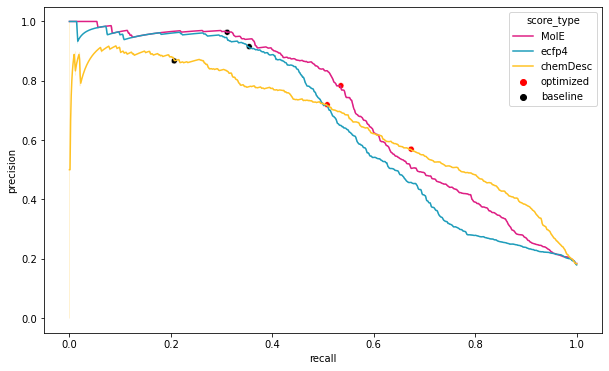

In [14]:
plt.figure(figsize=(10,6))


sns.lineplot(data=validation_prc.reset_index(), x="recall", y="precision", hue="representation",
             palette={"MolE":"#DE1F84", "ecfp4":"#1F9DBB", "chemDesc":"#FFC224"})

sns.scatterplot(data=optimal_thresholds, x="validation_recall", y="validation_precision", hue="score_type",
                palette={"optimized":"red", "baseline":"black"})

<AxesSubplot:xlabel='recall', ylabel='precision'>

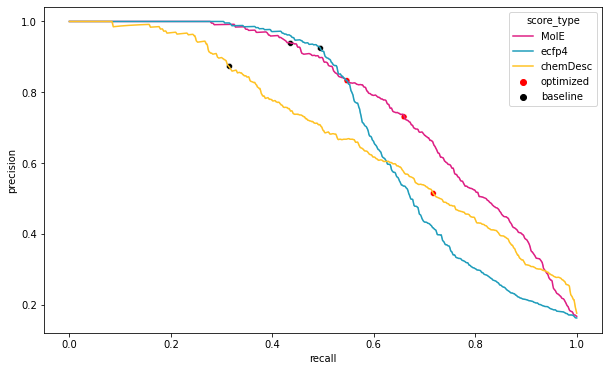

In [15]:
test_prc = pd.concat([gather_prc(r, "test") for r in evalpreds_dict.keys()])

plt.figure(figsize=(10,6))


sns.lineplot(data=test_prc.reset_index(), x="recall", y="precision", hue="representation",
             palette={"MolE":"#DE1F84", "ecfp4":"#1F9DBB", "chemDesc":"#FFC224"})

sns.scatterplot(data=optimal_thresholds, x="test_recall", y="test_precision", hue="score_type",
                palette={"optimized":"red", "baseline":"black"})

## Exploring Test Set

In [42]:
def gather_testpredictions(data_df, optimal_threshold):

    # Gather the predictions from the test set
    test_preds = data_df[data_df["split"] == "test"]

    # Determine positive predictions using threshold
    test_preds["y_pred"] = test_preds["1"].apply(lambda x: 1 if x >= optimal_threshold else 0)

    # Pivot into table
    test_preds[["prestwick_ID", "strain"]] = test_preds["pred_id"].str.split(":", expand=True)

    test_preds = test_preds.pivot(index="prestwick_ID", columns="strain", values="y_pred")

    return test_preds

In [48]:
# Gather optimized prediction on test set
mole_testpreds = gather_testpredictions(mole_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "MolE") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])

ecfp4_testpreds = gather_testpredictions(ecfp4_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "ecfp4") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])

chemDesc_testpreds = gather_testpredictions(chemdesc_evalpreds, optimal_thresholds.loc[(optimal_thresholds["representation"] == "chemDesc") & 
                                                                                (optimal_thresholds["score_type"] == "optimized"), "threshold"].values[0])                                                                                


# Gather the ground truth
test_truth = screen_df.loc[split_df[split_df["split"] == "test"].index]

/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/roberto_olayo/miniconda3/envs/molclr/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Compare ground truth to predictions

In [61]:
# Read information
prestwick_info = pd.read_csv(os.path.join(SCREEN_DATA_DIR, "prestwick_library_screened.tsv.gz"), sep='\t', index_col=["prestwick_ID"])
prestwick_info = prestwick_info[["chemical name"]]

In [63]:


true_agg = test_truth.sum(axis=1).to_frame().rename(columns={0: "true_count"})
mole_agg = mole_testpreds.sum(axis=1).to_frame().rename(columns={0: "MolE"})
ecfp4_agg = ecfp4_testpreds.sum(axis=1).to_frame().rename(columns={0: "ecfp4"})
chemdesc_agg = chemDesc_testpreds.sum(axis=1).to_frame().rename(columns={0: "chemDesc"})

# Join the dataframes
all_preds = prestwick_info.join(true_agg).join(mole_agg).join(ecfp4_agg).join(chemdesc_agg)

all_preds.loc[all_preds["true_count"] > 10]


,chemical name,true_count,MolE,ecfp4,chemDesc
prestwick_ID,,,,,
Prestw-1,Azaguanine-8,16.0,0.0,0.0,0.0
Prestw-1010,Talampicillin hydrochloride,34.0,29.0,34.0,34.0
Prestw-1024,Nifurtimox,35.0,38.0,40.0,37.0
Prestw-1028,Benzathine benzylpenicillin,35.0,30.0,40.0,39.0
Prestw-1040,Pyrvinium pamoate,20.0,31.0,0.0,27.0
Prestw-1045,Sertaconazole nitrate,18.0,28.0,38.0,33.0
Prestw-1067,Ticarcillin sodium,38.0,37.0,38.0,40.0
Prestw-1106,Meropenem,38.0,32.0,0.0,34.0
Prestw-1109,Rifabutin,40.0,40.0,40.0,40.0


Look at heatmaps

In [70]:
chemDesc_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "chemDesc"})

strain,Akkermansia muciniphila (NT5021),Bacteroides caccae (NT5050),Bacteroides fragilis (ET) (NT5033),Bacteroides fragilis (NT) (NT5003),Bacteroides ovatus (NT5054),Bacteroides thetaiotaomicron (NT5004),Bacteroides uniformis (NT5002),Bacteroides vulgatus (NT5001),Bacteroides xylanisolvens (NT5064),Bifidobacterium adolescentis (NT5022),...,Parabacteroides merdae (NT5071),Prevotella copri (NT5019),Roseburia hominis (NT5079),Roseburia intestinalis (NT5011),Ruminococcus bromii (NT5045),Ruminococcus gnavus (NT5046),Ruminococcus torques (NT5047),Streptococcus parasanguinis (NT5072),Streptococcus salivarius (NT5038),Veillonella parvula (NT5017)
chemDesc,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0


In [85]:
prest_id = "Prestw-1167"

# Gather the predictions
chem_predictions = pd.concat([chemDesc_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "chemDesc"}),
                              ecfp4_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "ecfp4"}),
                              mole_testpreds.loc[prest_id].to_frame().transpose().rename(index={prest_id: "MolE"}),
                              test_truth.loc[prest_id].to_frame().transpose().rename(index={prest_id: "True_activity"})])

chem_predictions 

,Akkermansia muciniphila (NT5021),Bacteroides caccae (NT5050),Bacteroides fragilis (ET) (NT5033),Bacteroides fragilis (NT) (NT5003),Bacteroides ovatus (NT5054),Bacteroides thetaiotaomicron (NT5004),Bacteroides uniformis (NT5002),Bacteroides vulgatus (NT5001),Bacteroides xylanisolvens (NT5064),Bifidobacterium adolescentis (NT5022),...,Parabacteroides merdae (NT5071),Prevotella copri (NT5019),Roseburia hominis (NT5079),Roseburia intestinalis (NT5011),Ruminococcus bromii (NT5045),Ruminococcus gnavus (NT5046),Ruminococcus torques (NT5047),Streptococcus parasanguinis (NT5072),Streptococcus salivarius (NT5038),Veillonella parvula (NT5017)
chemDesc,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,1,1,0,0,0,0
ecfp4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MolE,0,0,1,1,1,0,1,1,0,1,...,1,1,1,1,1,1,0,1,1,0
True_activity,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:>

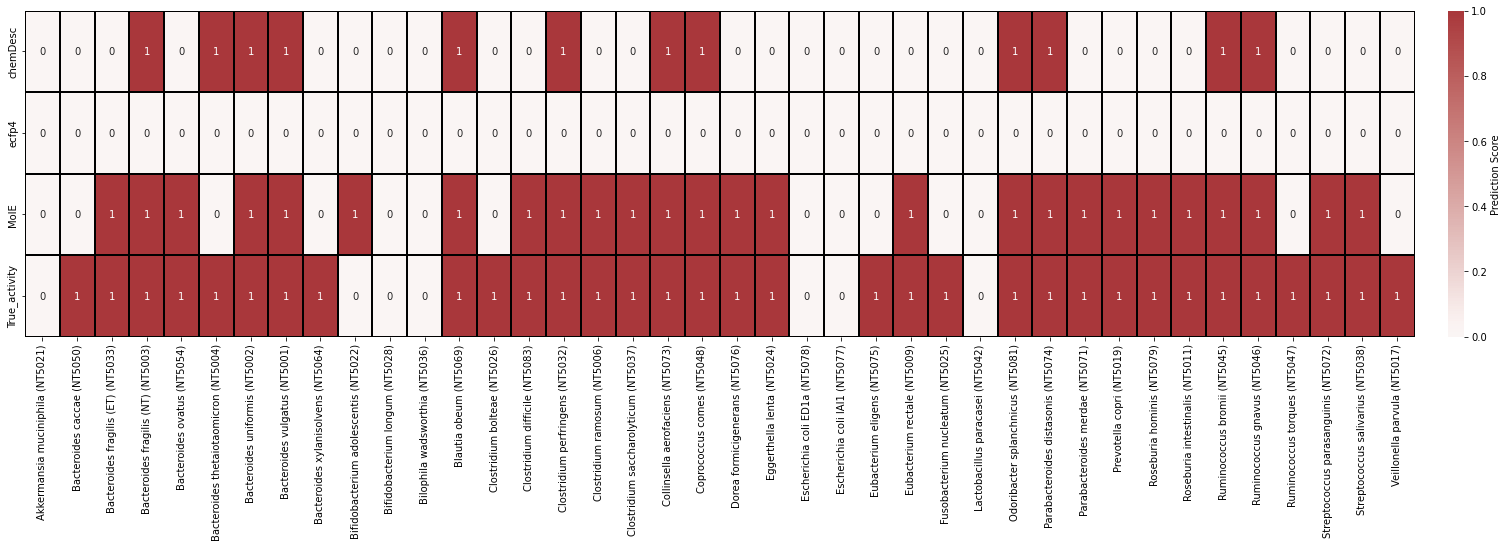

In [86]:
plt.figure(figsize=(30,6))

sns.heatmap(chem_predictions,cmap="vlag", robust=False, center=0, 
            linewidths=0.1, linecolor="black", annot=True,
            cbar_kws={"label": "Prediction Score", "pad": 0.02})

## Save models

In [87]:
import pickle
from datetime import datetime

In [88]:
#MolE
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"MolE-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(mole_model, file)


# ECFP4
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"ecfp4-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(ecfp4_model, file)


# Chemical Descriptor
now = datetime.now()
model_file = os.path.join(OUTPUT_DIR, f"chemDesc-XGBoost-{now.strftime('%d.%m.%Y_%H.%M')}.pkl")
with open(model_file, "wb") as file:
    pickle.dump(chemdesc_model, file)

In [90]:
optimal_thresholds.to_csv(os.path.join(OUTPUT_DIR, "optimal_thresholds.tsv.gz"), sep='\t', index=False)